# Entity Resolution project @ Wavestone
## Entity Matching

> *Datasets information from [here](https://data.dws.informatik.uni-mannheim.de/benchmarkmatchingtasks/index.html)*

> **Tristan PERROT**


## Import libraries


In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os

import torch

device = torch.device('cuda:2' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cuda:2


In [3]:
while 'model' not in os.listdir():
    os.chdir('..')

In [4]:
MODEL_NAME = ''
DATA_NAME = 'wdc_xlarge_computers'
COMPUTER = 'gpu5.enst.fr:' + str(device)[-1:]
DATA_DIR = os.path.join('data', DATA_NAME)

## Pre-processing

In [5]:
import time

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import torch.nn as nn
from sentence_transformers import CrossEncoder, InputExample, SentencesDataset
from sentence_transformers.cross_encoder.evaluation import \
    CEBinaryClassificationEvaluator
from sklearn.metrics import (classification_report, confusion_matrix,
                             roc_auc_score, roc_curve)
from torch.nn import BCEWithLogitsLoss
from torch.utils.data import DataLoader

from model.utils import load_data

In [8]:
!python import_data.py --dataset $DATA_NAME


Downloaded dataset: wdc_xlarge_computers 



In [9]:
table_a_serialized, table_b_serialized, X_train_ids, y_train, X_valid_ids, y_valid, X_test_ids, y_test = load_data(DATA_DIR,)

Table A columns:
        column_name                                       data_example
1       description                                                NaN
2  specTableContent   Categorie Geheugen intern Merk Corsair Produc...
3             title   "Corsair Vengeance LPX CMK64GX4M4A2666C16 - P... 

Table B columns:
        column_name                                       data_example
1       description                                                NaN
2  specTableContent   Categorie Geheugen intern Merk Corsair Produc...
3             title   "Corsair Vengeance LPX CMK64GX4M4A2666C16 - P... 

Serialized entities 



In [10]:
X1_train, X2_train = [table_a_serialized[i[0]] for i in X_train_ids], [table_b_serialized[i[1]] for i in X_train_ids]
X1_valid, X2_valid = [table_a_serialized[i[0]] for i in X_valid_ids], [table_b_serialized[i[1]] for i in X_valid_ids]
X1_test, X2_test = [table_a_serialized[i[0]] for i in X_test_ids], [table_b_serialized[i[1]] for i in X_test_ids]

In [11]:
# Display the first 5 samples of the training set
for i in range(5):
    print(f'Sample {i}:')
    print(f'Entity1: {X1_train[i]}')
    print(f'Entity2: {X2_train[i]}')
    print(f'Label: {y_train[i]}')
    print()

Sample 0:
Entity1: [COL] brand [VAL] "Corsair"@en [COL] description [VAL] "DDR4, 2666MHz, CL16, 1.2v, XMP 2.0, Lifetime Warranty"@en  [COL] specTableContent [VAL]  Memory Type DDR4 (PC4-21300) Capacity 64GB (4 x 16GB) Tested Speed 2666MHz Tested Latency 16-18-18-35 Tested Voltage 1.2V Registered / Unbuffered Unbuffered Error Checking Non-ECC Memory Features XMP 2.0, Vengeance LPX Heatsink [COL] title [VAL]  "Corsair Vengeance LPX Black 64GB (4x16GB) DDR4 PC4-21300 2666MHz Quad Channel Kit "@en 4x16GB | CMK64GX4M4A2666C16 Novatech"@en
Entity2: [COL] brand [VAL]  [COL] description [VAL]  [COL] specTableContent [VAL]  Categorie Geheugen intern Merk Corsair Productserie Vengeance LPX Product Corsair Vengeance LPX CMK64GX4M4A2666C16 Uitvoering Corsair Vengeance LPX CMK64GX4M4A2666C16 EAN 0843591071833 SKU CMK64GX4M4A2666C16 Tweakers ID 467945 Productprijs € 749,- Pakketpost tot € 50,- € 0,- iDeal € 0,- Totaal € 749,- Onjuiste prijs melden Productprijs € 752,- Pakketpost (vanaf € 36,24) € 0,

In [12]:
train_datasets = [InputExample(texts=[X1_train[i], X2_train[i]], label=y_train[i]) for i in range(len(X_train_ids))]
valid_datasets = [InputExample(texts=[X1_valid[i], X2_valid[i]], label=y_valid[i]) for i in range(len(X_valid_ids))]
test_datasets = [InputExample(texts=[X1_test[i], X2_test[i]], label=y_test[i]) for i in range(len(X_test_ids))]
train_loader = DataLoader(train_datasets, shuffle=True, batch_size=16, num_workers=0)
valid_loader = DataLoader(valid_datasets, shuffle=False, batch_size=16, num_workers=0)
test_examples = DataLoader(test_datasets, shuffle=False, batch_size=16, num_workers=0)

valid_evaluation_set = [(e1, e2) for e1, e2 in zip(X1_valid, X2_valid)]

In [13]:
EPOCHS = 3
LR = 2e-5
WEIGHT_DECAY = 0.01
WARMUP_STEPS = 200
CLASSIFIER_DROPOUT = None
threshold = 0.65

loss_fct = BCEWithLogitsLoss()

def callback(score, epoch, steps):
    print(f'Epoch {epoch} - Score {score} - Steps {steps}')

In [14]:
final_table_exports = ""
results = {}

In [32]:
def show_results():
    global results
    roc_curve_fig, roc_curve_ax = plt.subplots(figsize=(10, 10))
    acc_threshold_fig, acc_threshold_ax = plt.subplots(figsize=(10, 10))
    prec_recall_threshold_fig, prec_recall_threshold_ax = plt.subplots(figsize=(10, 10))
    f1_threshold_fig, f1_threshold_ax = plt.subplots(figsize=(10, 10))

    colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']

    for i, (model_name, (logits, train_time)) in enumerate(results.items()):
        y_pred = logits > threshold
        y_true = y_test
        print(f'Model: {model_name}')
        print(classification_report(y_true, y_pred))
        print(f'AUC: {roc_auc_score(y_true, logits)}')
        print(f'Train time: {train_time}')
        print()
        fpr, tpr, _ = roc_curve(y_true, logits)
        roc_curve_ax.plot(fpr, tpr, label=model_name)

        # Confusion matrix
        plt.figure()
        cm = confusion_matrix(y_true, y_pred)
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
        plt.title(f'Confusion matrix for {model_name}')
        plt.xlabel('Predicted')
        plt.ylabel('True')

        thresholds = np.linspace(0, 1, 100)
        accuracies = []
        precions = []
        recalls = []
        f1_scores = []
        for th in thresholds:
            y_pred = logits > th
            accuracies.append(np.mean(y_pred == y_true))
            precions.append(np.sum(y_pred * y_true) / np.sum(y_pred) if np.sum(y_pred) != 0 else 1)
            recalls.append(np.sum(y_pred * y_true) / np.sum(y_true))
            f1_scores.append(2 * precions[-1] * recalls[-1] / (precions[-1] + recalls[-1]) if precions[-1] + recalls[-1] != 0 else 0)
        acc_threshold_ax.plot(thresholds, accuracies, label=model_name)
        prec_recall_threshold_ax.plot(thresholds, precions, label=model_name + " precision", color=colors[i])
        prec_recall_threshold_ax.plot(thresholds, recalls, label=model_name + " recall", color=colors[i], linestyle='--')
        f1_threshold_ax.plot(thresholds, f1_scores, label=model_name)


    
    roc_curve_ax.plot([0, 1], [0, 1], 'k--')
    roc_curve_ax.set_xlabel('False Positive Rate')
    roc_curve_ax.set_ylabel('True Positive Rate')
    roc_curve_ax.set_title('ROC curve')
    roc_curve_ax.legend()

    acc_threshold_ax.set_xlabel('Threshold')
    acc_threshold_ax.set_ylabel('Accuracy')
    acc_threshold_ax.set_title('Accuracy vs Threshold')
    acc_threshold_ax.legend()

    prec_recall_threshold_ax.set_xlabel('Threshold')
    prec_recall_threshold_ax.set_ylabel('Precision/Recall')
    prec_recall_threshold_ax.set_title('Precision/Recall vs Threshold')
    prec_recall_threshold_ax.axvline(x=threshold, color='k', linestyle='--', label=f'Threshold = {threshold}')
    prec_recall_threshold_ax.legend()

    f1_threshold_ax.set_xlabel('Threshold')
    f1_threshold_ax.set_ylabel('F1 Score')
    f1_threshold_ax.set_title('F1 Score vs Threshold')
    f1_threshold_ax.axvline(x=threshold, color='k', linestyle='--', label=f'Threshold = {threshold}')
    f1_threshold_ax.legend()

    plt.show()

### MS Marco MiniLM l-12

- Architecture: MiniLM-L-12
- Parameters: ~33 million
- Layers: 12 Transformer layers
- Hidden Size: 384
- Attention Heads: 12
- Link to the model: [here](https://huggingface.co/cross-encoder/ms-marco-TinyBERT-L-2-v2)
- MS MARCO Passage Retrieval is a large dataset with real user queries from Bing search engine with annotated relevant text passages.

In [16]:
MODEL_NAME = 'cross-encoder/ms-marco-MiniLM-L-12-v2'
OUTPUT_PATH = os.path.join('results', DATA_NAME, MODEL_NAME)
os.makedirs(OUTPUT_PATH, exist_ok=True)

In [17]:
model = CrossEncoder(MODEL_NAME, num_labels=1, device=device, classifier_dropout=CLASSIFIER_DROPOUT, default_activation_function=nn.Sigmoid())

In [18]:
start_train_time = time.time()
model.fit(train_dataloader=train_loader,
            loss_fct=loss_fct,
            evaluator=CEBinaryClassificationEvaluator(valid_evaluation_set, labels=y_valid, show_progress_bar=True),
            epochs=EPOCHS,
            warmup_steps=WARMUP_STEPS,
            output_path=OUTPUT_PATH,
            callback=callback,
            optimizer_params={'lr': LR},
            weight_decay=WEIGHT_DECAY,
            show_progress_bar=True)
train_time = time.time() - start_train_time

Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

Iteration:   0%|          | 0/3424 [00:00<?, ?it/s]

Batches:   0%|          | 0/428 [00:00<?, ?it/s]

Epoch 0 - Score 0.958388037846556 - Steps -1


Iteration:   0%|          | 0/3424 [00:00<?, ?it/s]

Batches:   0%|          | 0/428 [00:00<?, ?it/s]

Epoch 1 - Score 0.979708065509299 - Steps -1


Iteration:   0%|          | 0/3424 [00:00<?, ?it/s]

Batches:   0%|          | 0/428 [00:00<?, ?it/s]

Epoch 2 - Score 0.9838400675641347 - Steps -1


In [19]:
logits = model.predict([[e1, e2] for e1, e2 in zip(X1_test, X2_test)], apply_softmax=True)
y_pred = logits > threshold
results[MODEL_NAME] = (logits, train_time)

In [20]:
# Exemple of prediction
print(f'Prediction: {y_pred[0]}')
print(f'Label: {y_test[0]}')
print(f'Sample 1: {X1_test[0]}')
print(f'Sample 2: {X2_test[0]}')

Prediction: False
Label: 0
Sample 1: [COL] brand [VAL] "Gigabyte"@en [COL] description [VAL] "GV-RX480G1 GAMING-4GD, Core Clock: 1202MHz, Boost Clock: 1290MHz, Memory: 4096MB 7000MHz GDDR5, Stream Processors: 2304, Crossfire Ready, VR Ready, FreeSync Ready, 3 Years Warranty"@en  [COL] specTableContent [VAL]  [COL] title [VAL]  "Gigabyte Radeon RX 480 G1 Gaming 4096MB GDDR5 PCI-Express Graphics Card"@en "▷ Gigabyte Gr… | OcUK"@en
Sample 2: [COL] brand [VAL] "Gigabyte"@en [COL] description [VAL] "GV-RX550GAMING OC-2GD, Boost: 1219MHz, Memory: 2048MB 7000MHz GDDR5, Stream Processors: 512, DirectX 12 Support, 3 Years Warranty"@en  [COL] specTableContent [VAL]  [COL] title [VAL]  "Gigabyte Radeon RX 550 Gaming OC 2048MB GDDR5 PCI-Express Graphics Card"@en "▷ Gigabyte Gr… | OcUK"@en


In [21]:
e1, e2 = X1_test[np.nonzero(y_test)[0][0]], X2_test[np.nonzero(y_test)[0][0]]
print('Entity 1:', e1)
print('Entity 2:', e2)
print(f'Label: {y_test[np.nonzero(y_test)[0][0]]}')
print(f'Prediction: {y_pred[np.nonzero(y_test)[0][0]]}')

Entity 1: [COL] brand [VAL] "Benq" [COL] description [VAL] "
                More>>>
                
                
                                                
                                            
                            Short summary description Benq ZOWIE RL2455 24" Full HD TN Grey computer monitor:
                            This short summary of the Benq ZOWIE RL2455 24" Full HD TN Grey computer monitor data-sheet is auto-generated and uses the product title and the first six key specs.
                            Benq ZOWIE RL2455, 24", 1920 x 1080 pixels, LED, 1 ms, 250 cd/m², Grey
                        
                                                                
                            Long summary description Benq ZOWIE RL2455 24" Full HD TN Grey computer monitor :
                            Benq ZOWIE RL2455. Display diagonal: 24", Display resolution: 1920 x 1080 pixels, HD type: Full HD, Display technology: TN, Display: LED, Response time: 1 m

### STS RoBERTa-base

- Architecture: RoBERTa-base
- Parameters: ~125 million
- Layers: 12 Transformer layers
- Hidden Size: 768
- Attention Heads: 12
- Link to the model: [here](https://huggingface.co/cross-encoder/stsb-roberta-base)
- Train to predict the similarity between two sentences

In [22]:
MODEL_NAME = 'cross-encoder/stsb-roberta-base'
OUTPUT_PATH = os.path.join('results', DATA_NAME, MODEL_NAME)
os.makedirs(OUTPUT_PATH, exist_ok=True)

In [23]:
model = CrossEncoder(MODEL_NAME, num_labels=1, device=device, classifier_dropout=CLASSIFIER_DROPOUT)

In [24]:
start_train_time = time.time()
model.fit(train_dataloader=train_loader,
            loss_fct=loss_fct,
            evaluator=CEBinaryClassificationEvaluator(valid_evaluation_set, labels=y_valid, show_progress_bar=True),
            epochs=EPOCHS,
            warmup_steps=WARMUP_STEPS,
            output_path=OUTPUT_PATH,
            callback=callback,
            optimizer_params={'lr': LR},
            weight_decay=WEIGHT_DECAY,
            show_progress_bar=True)
train_time = time.time() - start_train_time

Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

Iteration:   0%|          | 0/3424 [00:00<?, ?it/s]

Batches:   0%|          | 0/428 [00:00<?, ?it/s]

Epoch 0 - Score 0.9756367874884289 - Steps -1


Iteration:   0%|          | 0/3424 [00:00<?, ?it/s]

Batches:   0%|          | 0/428 [00:00<?, ?it/s]

Epoch 1 - Score 0.9894025152956316 - Steps -1


Iteration:   0%|          | 0/3424 [00:00<?, ?it/s]

Batches:   0%|          | 0/428 [00:00<?, ?it/s]

Epoch 2 - Score 0.9924115272035009 - Steps -1


In [25]:
logits = model.predict([[e1, e2] for e1, e2 in zip(X1_test, X2_test)], apply_softmax=True)
y_pred = logits > threshold
results[MODEL_NAME] = (logits, train_time)

### STS DistilRoBERTa-base

- Architecture: DistilRoBERTa-base
- Parameters: ~82 million
- Layers: 6 Transformer layers
- Hidden Size: 768
- Attention Heads: 12
- Link to the model: [here](https://huggingface.co/cross-encoder/stsb-distilroberta-base)
- Train to predict the similarity between two sentences

In [26]:
MODEL_NAME = 'cross-encoder/stsb-distilroberta-base'
OUTPUT_PATH = os.path.join('results', DATA_NAME, MODEL_NAME)
os.makedirs(OUTPUT_PATH, exist_ok=True)

In [27]:
model = CrossEncoder(MODEL_NAME, num_labels=1, device=device, classifier_dropout=CLASSIFIER_DROPOUT)

In [28]:
start_train_time = time.time()
model.fit(train_dataloader=train_loader,
            loss_fct=loss_fct,
            evaluator=CEBinaryClassificationEvaluator(valid_evaluation_set, labels=y_valid, show_progress_bar=True),
            epochs=EPOCHS,
            warmup_steps=WARMUP_STEPS,
            output_path=OUTPUT_PATH,
            callback=callback,
            optimizer_params={'lr': LR},
            weight_decay=WEIGHT_DECAY,
            show_progress_bar=True)
train_time = time.time() - start_train_time

Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

Iteration:   0%|          | 0/3424 [00:00<?, ?it/s]

Batches:   0%|          | 0/428 [00:00<?, ?it/s]

Epoch 0 - Score 0.9625083243167301 - Steps -1


Iteration:   0%|          | 0/3424 [00:00<?, ?it/s]

Batches:   0%|          | 0/428 [00:00<?, ?it/s]

Epoch 1 - Score 0.9797297793881904 - Steps -1


Iteration:   0%|          | 0/3424 [00:00<?, ?it/s]

Batches:   0%|          | 0/428 [00:00<?, ?it/s]

Epoch 2 - Score 0.985315825435919 - Steps -1


In [29]:
threshold = 0.65

In [30]:
logits = model.predict([[e1, e2] for e1, e2 in zip(X1_test, X2_test)], apply_softmax=True)
y_pred = logits > threshold
results[MODEL_NAME] = (logits, train_time)

Model: cross-encoder/ms-marco-MiniLM-L-12-v2
              precision    recall  f1-score   support

           0       0.97      0.97      0.97       800
           1       0.92      0.93      0.93       300

    accuracy                           0.96      1100
   macro avg       0.95      0.95      0.95      1100
weighted avg       0.96      0.96      0.96      1100

AUC: 0.9900291666666667
Train time: 1326.510269165039

Model: cross-encoder/stsb-roberta-base
              precision    recall  f1-score   support

           0       0.98      0.98      0.98       800
           1       0.96      0.94      0.95       300

    accuracy                           0.97      1100
   macro avg       0.97      0.96      0.97      1100
weighted avg       0.97      0.97      0.97      1100

AUC: 0.9941875
Train time: 3695.6184322834015

Model: cross-encoder/stsb-distilroberta-base
              precision    recall  f1-score   support

           0       0.96      0.98      0.97       800
      

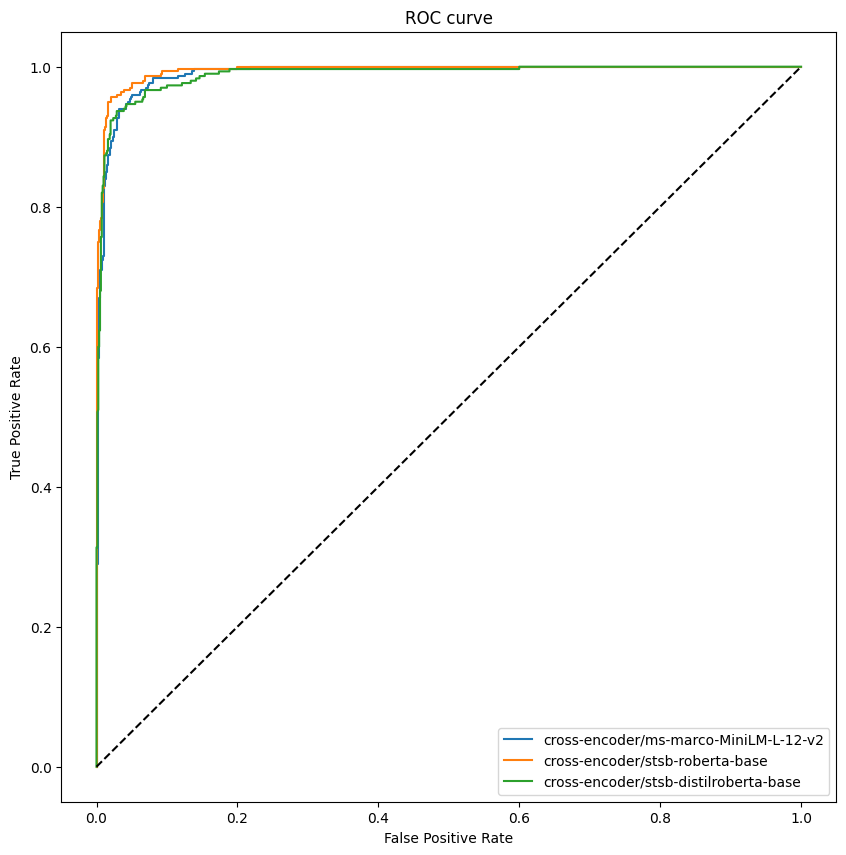

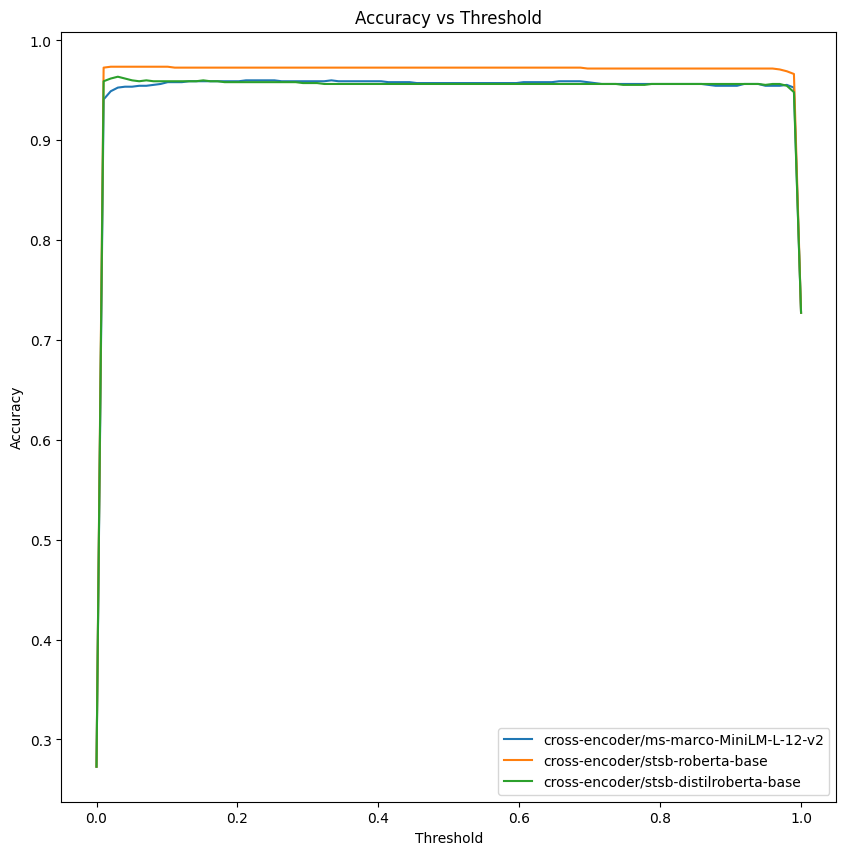

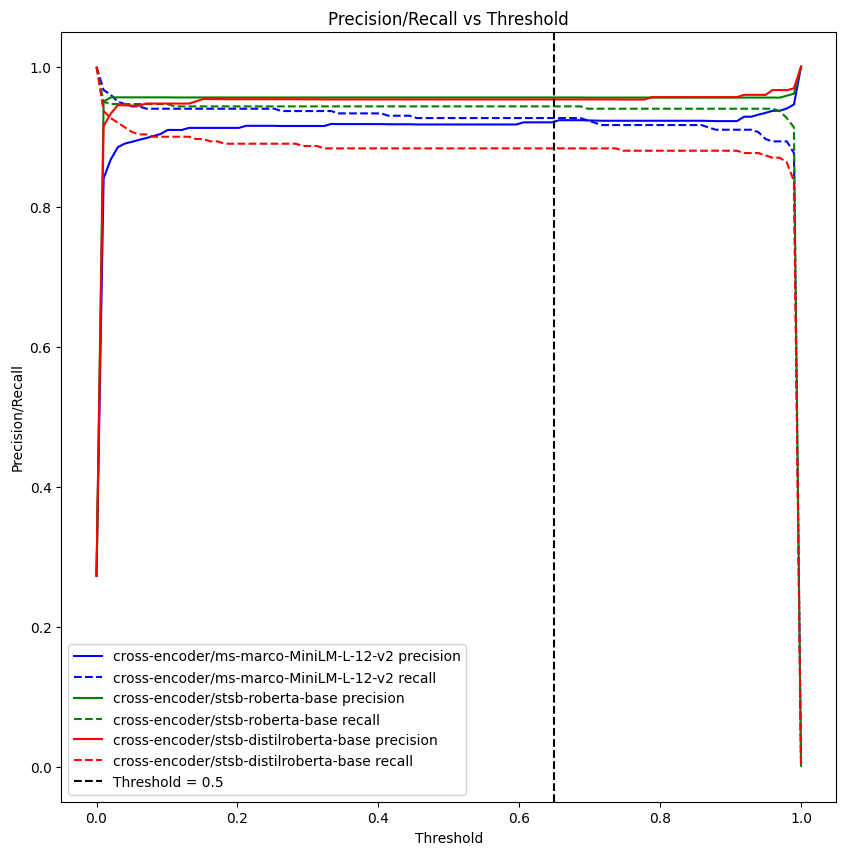

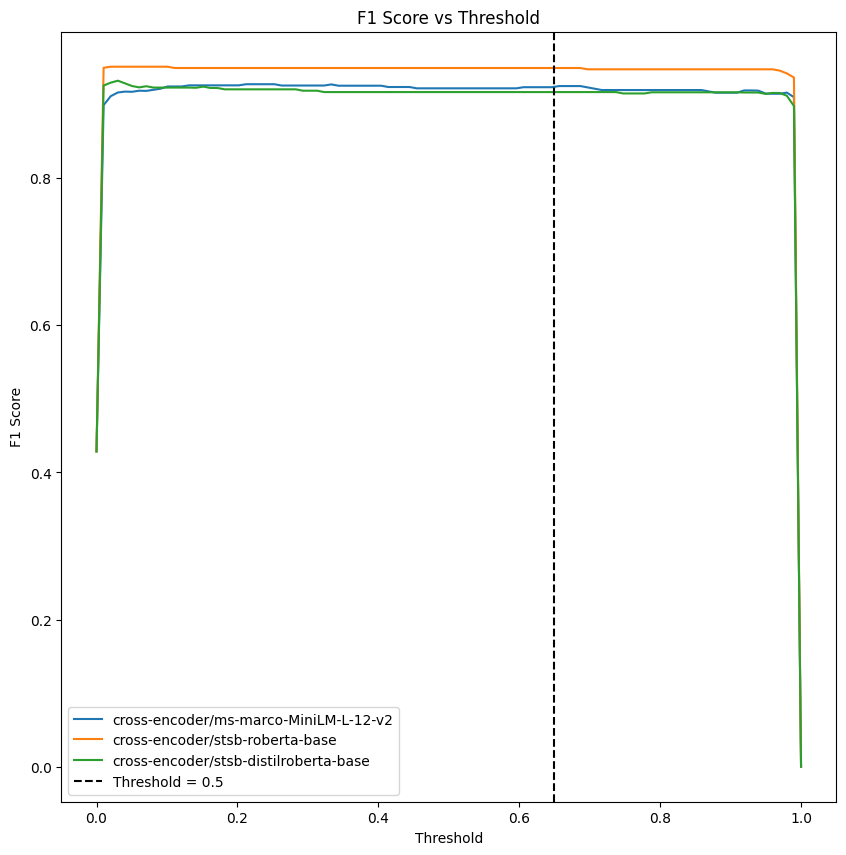

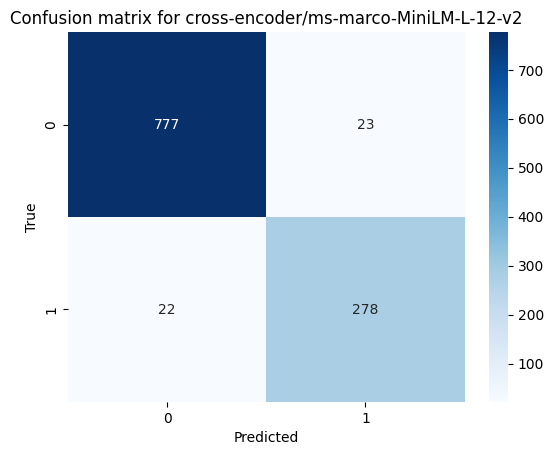

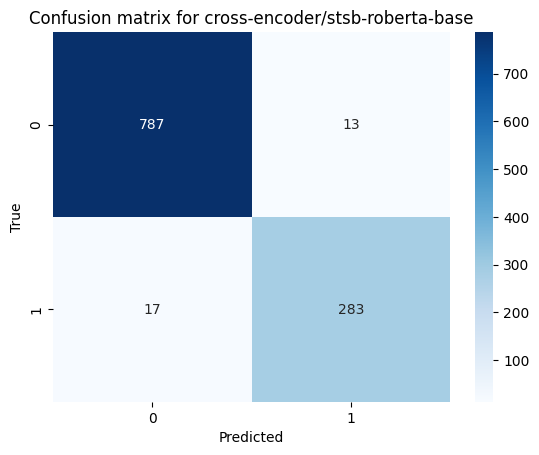

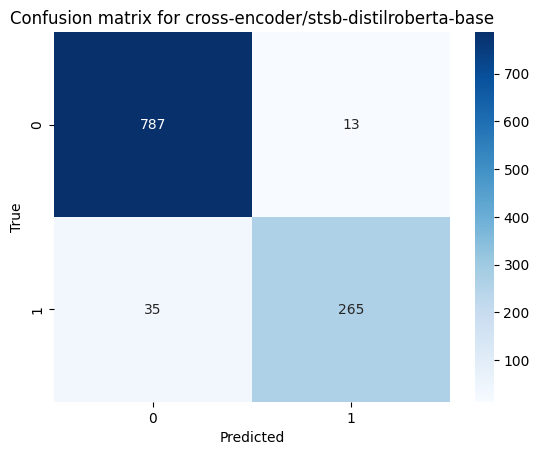

In [31]:
show_results()